In [31]:
from tqdm.notebook import tqdm

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from matplotlib import colorbar as mbar
import seaborn as sns

from scipy.ndimage import gaussian_filter as smooth

from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

from sklearn.metrics.pairwise import cosine_similarity as cosine
from sklearn.metrics.pairwise import euclidean_distances as eu_dist
from scipy.linalg import subspace_angles as angle

from scipy.stats import permutation_test
from scipy.stats import mannwhitneyu as mnu
from scipy.stats import spearmanr as spearman
from scipy.stats import zscore

from scipy.io import loadmat

import warnings
warnings.filterwarnings('ignore')

from IPython.display import clear_output

# Definitions

In [ ]:
def movavg(input, win=[], step=[]):
    '''
    Args:
        input: matrix of input data, with shape (Neurons,Stimuli,Timepoints)
        win:   size of the window for moving averge
        step:  step size for moving forward
    Returns:
        output:     matrix of output data, with shape (Neurons,Stimuli,Timepoints),
                    where Timepoints are following the moving average process
        timestamps: (N,) vector of timepoints, corresponding to the output data, 
                    where N is the number of timepoints following the moving average process
    '''

    if not win: win = input.shape[2] // 25
    if not step: step = win // 10
    
    bins = [np.arange(0,input.shape[2]-win+1,step), 
            np.arange(win, input.shape[2]+1, step)]
    
    nbins = np.array(bins).shape[1]
    output = np.nan * np.zeros((input.shape[0], input.shape[1], nbins))

    timestamps = []
    counter_bin = 0
    for bin_st, bin_end in tqdm(zip(bins[0],bins[1])):
        timestamps.append(np.nanmean([bin_st, bin_end]))
        output[:,:,counter_bin] = np.nanmean(input[:,:,bin_st:bin_end], axis=2)
        counter_bin += 1

    return output, np.array(timestamps)


def m_plot(input_data, colors, error_method='sem', smooth_win=0, labels=[], plot_title='', timepoints=[], figure_size=(8,3)):
    '''
    Args:
        input_data:   (N,M,T) matrix of input data, (Conditions,Samples,Timepoints)
        colors:       (N,4) matrix of colors for the generated plots in [R,G,B,FaceAlpha] format,
                      where N is the number of conditions. FaceAlpha in the scale=[0-255]
        error_method: variation metric ('sem' & 'std')
        smooth_win:   smoothing window
        
        labels:       (N,) list of labels for the generated plots, where N is the number of conditions
        plot_title:   title of the generated plot
        timepoints:   (N,) vaetor of timepoints
        figure_size:  two-item tuple containing width and height of the figure
    Returns:
        none
    '''

    colors = np.array(colors) / np.array(255)
    if not labels: labels=['']*len(input_data)
    timepoints = np.array(timepoints)
    if timepoints.size==0: timepoints = np.arange(0,input_data[0].shape[1])
    
    plt.figure(figsize=figure_size)
    # sns.set_style('darkgrid')
    for i,Cond in enumerate(input_data):
        data_ave = smooth(np.nanmean(Cond, axis=0), smooth_win, axes=0)
        data_std = smooth(np.nanstd(Cond, axis=0), smooth_win, axes=0)
        
        if error_method=='sem':
            error_up  = data_ave + (data_std / np.sqrt(Cond.shape[0]))
            error_low = data_ave - (data_std / np.sqrt(Cond.shape[0]))
        elif error_method=='std':
            error_up  = data_ave + data_std
            error_low = data_ave - data_std

        plt.fill_between(timepoints, error_up, error_low, color=colors[i], label='_nolegend_')
        plt.plot(timepoints, data_ave, color=colors[i,:3], lw=3, label=labels[i])
    
    ylim = plt.ylim()
    plt.fill_between([0, 80], [ylim[0], ylim[0]], [ylim[1], ylim[1]], color='gray', alpha=.2, edgecolor=None)
    plt.legend(frameon=False, fontsize=10)
    plt.title(plot_title)
    plt.tight_layout()


def rand_idx_gen(cyles, cat_inds, stim_num, replacement=False):
    '''
    Args:
        cyles:       number repetitions or cycles
        cat_inds:    (N,) list of indices in each category/condition, where N is the number of categories/conditions,
                     and each item in the list is a np.array of indices for that category/condition.
        stim_num:    number of samples for each category/condition
        replacement: if True, sampling will be with replacement
    Returns:
        idx_rand: (N,M) np.array of the generated random indices, (cyles,cat_inds*stim_num)
    '''
    np.random.seed(15)
    idx_rand = []

    for iCycle in range(cyles):
        tmp_rand_tdx = []
        for i,iCat in enumerate(cat_inds):
            tmp_rand_tdx = np.concatenate((tmp_rand_tdx, iCat[np.random.choice(iCat.shape[0], stim_num, replace=replacement)]), axis=0)
        idx_rand.append(tmp_rand_tdx)

    return np.array(idx_rand).astype('int')


def comp_permute_p(data_dist_1, data_dist_2, permute_reps=100001):
    '''
    Args:
        data_dist_1: (N,) vector of data 1st distribution (Samples,)
        data_dist_2: (N,) vector of data 2nd distribution (Samples,)
        permute_reps:  number of repetitions for the permutation process
    Returns:
        p_val: two-tailed p-value of the permutation process for [data_dist_2 - data_dist_1]
    '''

    def tmp_test_stat(x, y, axis):
        return np.nanmean(x, axis=axis) - np.nanmean(y, axis=axis)
    
    p_val = np.nan
    p_val = permutation_test(data=(data_dist_2, data_dist_1), statistic=tmp_test_stat, vectorized=True, axis=0, random_state=15, n_resamples=permute_reps).pvalue

    return p_val

In [ ]:
# load data
FigDir = '../Results/dimred/'

FileDir_IT = '../Data/Resp_IT.mat'
temp_file_IT = loadmat(FileDir_IT)

FileDir_PFC = '../Data/Resp_PFC.mat'
temp_file_PFC = loadmat(FileDir_PFC)

# parameters
SmoothWin = 20
step = 1
time_base = 90 # formerly, it was set to 80

# load neural data
resp_itc, time_stamps  = movavg(temp_file_IT['resp_it'], SmoothWin, step)
resp_pfc, time_stamps  = movavg(temp_file_PFC['resp_pfc'], SmoothWin, step)
time_stamps -= time_base

# color
color_itc, color_pfc = [255, 187, 112, 80], [129, 104, 157, 80]
color_itc_n, color_pfc_n = np.array(color_itc)/255, np.array(color_pfc)/255

# sub-sampling
cycle_num = 200
trn_portion = .7

indc1 = np.arange(0,175,1)
indc2 = np.arange(175,335,1)
stim_num = round(min([indc1.shape[0], indc2.shape[0]]) * trn_portion)
cat_inds = [indc1,indc2]
idx_rand_anim = rand_idx_gen(cycle_num, cat_inds, stim_num, replacement=False)
labels_anim = np.concatenate( (np.ones(stim_num).T, 2*np.ones(stim_num).T) )

indc1 = np.arange(0,35,1)
indc2 = np.arange(35,75,1)
stim_num = round(min([indc1.shape[0], indc2.shape[0]]) * trn_portion)
cat_inds = [indc1,indc2]
idx_rand_fb = rand_idx_gen(cycle_num, cat_inds, stim_num, replacement=False)
labels_fb = np.concatenate( (np.ones(stim_num).T, 2*np.ones(stim_num).T) )


0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [ ]:
wt_fb_itc, wt_fb_pfc, wt_anim_itc, wt_anim_pfc = [], [], [], []
cosine_itc, cosine_pfc, dist_itc, dist_pfc = [], [], [], []

for icycle in tqdm(range(cycle_num)):
    tmp_wt_fb_itc, tmp_wt_fb_pfc, tmp_wt_anim_itc, tmp_wt_anim_pfc = [], [], [], []
    tmp_cosine_itc, tmp_cosine_pfc, tmp_dist_itc, tmp_dist_pfc = [], [], [], []

    for itime in range(resp_itc.shape[2]):
        lda_fb = LDA(shrinkage='auto', solver='eigen').fit(resp_itc[:,idx_rand_fb[icycle],itime].T, labels_fb)
        axis_fb = lda_fb.coef_[0]
        
        lda_anim = LDA(shrinkage='auto', solver='eigen').fit(resp_itc[:,idx_rand_anim[icycle],itime].T, labels_anim)
        axis_anim = lda_anim.coef_[0]
        
        tmp_wt_fb_itc.append(axis_fb)
        tmp_wt_anim_itc.append(axis_anim)
        tmp_cosine_itc.append(cosine(axis_fb.reshape(1,-1), axis_anim.reshape(1,-1)))
        tmp_dist_itc.append(eu_dist(axis_fb.reshape(1,-1), axis_anim.reshape(1,-1)))

        lda_fb = LDA(shrinkage='auto', solver='eigen').fit(resp_pfc[:,idx_rand_fb[icycle],itime].T, labels_fb)
        axis_fb = lda_fb.coef_[0]
        
        lda_anim = LDA(shrinkage='auto', solver='eigen').fit(resp_pfc[:,idx_rand_anim[icycle],itime].T, labels_anim)
        axis_anim = lda_anim.coef_[0]
        
        tmp_wt_fb_pfc.append(axis_fb)
        tmp_wt_anim_pfc.append(axis_anim)
        tmp_cosine_pfc.append(cosine(axis_fb.reshape(1,-1), axis_anim.reshape(1,-1)))
        tmp_dist_pfc.append(eu_dist(axis_fb.reshape(1,-1), axis_anim.reshape(1,-1)))

    wt_fb_itc.append(np.array(tmp_wt_fb_itc).T)
    wt_anim_itc.append(np.array(tmp_wt_anim_itc).T)
    wt_fb_pfc.append(np.array(tmp_wt_fb_pfc).T)
    wt_anim_pfc.append(np.array(tmp_wt_anim_pfc).T)

    cosine_itc.append(np.array(tmp_cosine_itc).reshape(1,-1)[0])
    cosine_pfc.append(np.array(tmp_cosine_pfc).reshape(1,-1)[0])
    dist_itc.append(np.array(tmp_dist_itc).reshape(1,-1)[0])
    dist_pfc.append(np.array(tmp_dist_pfc).reshape(1,-1)[0])


wt_fb_itc = np.array(wt_fb_itc)
wt_anim_itc = np.array(wt_anim_itc)
wt_fb_pfc = np.array(wt_fb_pfc)
wt_anim_pfc = np.array(wt_anim_pfc)

cosine_itc = np.array(cosine_itc)
cosine_pfc = np.array(cosine_pfc)
dist_itc = np.array(dist_itc)
dist_pfc = np.array(dist_pfc)

  0%|          | 0/200 [00:00<?, ?it/s]

In [30]:
np.random.seed(15)
# null_dist = np.random.normal(0,1, size=cycle_num)
null_dist = np.random.uniform(-1,1, size=cycle_num)

p_itc = np.zeros_like(time_stamps) * np.nan
p_pfc = np.copy(p_itc)

for itime in tqdm(range(cosine_itc.shape[1])):
    p_itc[itime] = comp_permute_p(cosine_itc[:,itime], null_dist)
    p_pfc[itime] = comp_permute_p(cosine_pfc[:,itime], null_dist)

  0%|          | 0/531 [00:00<?, ?it/s]

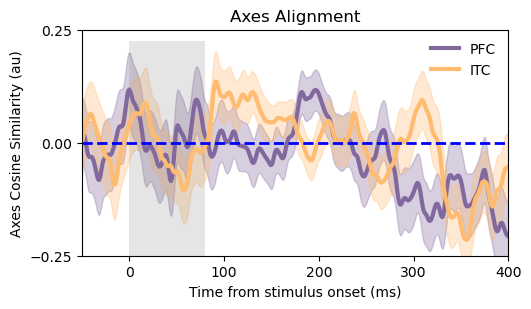

In [32]:
smooth_win = 2
plot_xlim = [-50,400]
plot_ylim = [-.25,.25]
figure_size = np.array((2.5,1.5)) * 2

m_plot([cosine_pfc,cosine_itc], [color_pfc,color_itc], error_method='std', 
       smooth_win=smooth_win, labels=['PFC','ITC'], plot_title=f'Axes Alignment', timepoints=time_stamps, figure_size=figure_size)

plt.axhline(0, ls='--', c='b', lw=figure_size[0]*.4)

plt.xlabel('Time from stimulus onset (ms)')
plt.xlim([plot_xlim[0],plot_xlim[1]])
plt.xticks([0,100,200,300,400])

plt.ylabel('Axes Cosine Similarity (au)')
plt.ylim(plot_ylim)
plt.yticks([plot_ylim[0], 0, plot_ylim[1]])

# plt.savefig(f'{FigDir}axes_align.svg', dpi=1000)
clear_output()

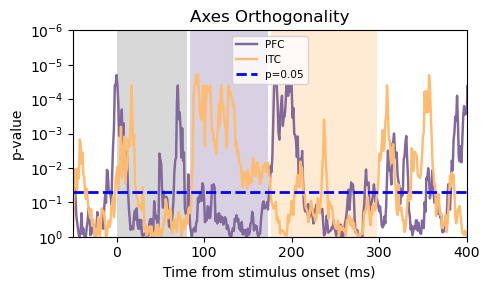

In [35]:
sig_thresh = .05
plot_xlim = [-50,400]
plot_ylim = [0,1]
figure_size = np.array((2.5,1.5)) * 2

plt.figure(figsize=figure_size)

plt.plot(time_stamps, p_pfc, lw=figure_size[0]*.35, color=color_pfc_n[:3], label='PFC')
plt.plot(time_stamps, p_itc, lw=figure_size[0]*.35, color=color_itc_n[:3], label='ITC')

sig_range_itc = [min(time_stamps[np.where((p_itc<sig_thresh))]), max(time_stamps[np.where((p_itc<sig_thresh))])]
sig_range_pfc = [min(time_stamps[np.where((p_pfc<sig_thresh))]), max(time_stamps[np.where((p_pfc<sig_thresh))])]

plt.fill_between([0, 80], [plt.ylim()[0], plt.ylim()[0]], [plt.ylim()[1], plt.ylim()[1]], color='gray', alpha=.3, edgecolor=None)
# plt.fill_between(sig_range_itc, [plt.ylim()[0], plt.ylim()[0]], [plt.ylim()[1], plt.ylim()[1]], color=color_itc_n[:3], alpha=.3, edgecolor=None)
# plt.fill_between(sig_range_pfc, [plt.ylim()[0], plt.ylim()[0]], [plt.ylim()[1], plt.ylim()[1]], color=color_pfc_n[:3], alpha=.3, edgecolor=None)
plt.fill_between([84,173], [plt.ylim()[0], plt.ylim()[0]], [plt.ylim()[1], plt.ylim()[1]], color=color_pfc_n[:3], alpha=.3, edgecolor=None)
plt.fill_between([177,297], [plt.ylim()[0], plt.ylim()[0]], [plt.ylim()[1], plt.ylim()[1]], color=color_itc_n[:3], alpha=.3, edgecolor=None)

plt.axhline(sig_thresh, ls='--', c='b', lw=figure_size[0]*.4, label=f'p={sig_thresh}')

plt.xlabel('Time from stimulus onset (ms)')
plt.xlim([plot_xlim[0],plot_xlim[1]])
plt.xticks([0,100,200,300,400])

plt.yscale('log')
plt.ylim(plot_ylim)
plt.yticks([1e0,1e-1,1e-2,1e-3,1e-4,1e-5,1e-6])
plt.ylabel('p-value')
plt.gca().invert_yaxis()
plt.minorticks_off()

plt.title('Axes Orthogonality')
plt.legend(fontsize=figure_size[0]*1.5)
plt.tight_layout()

# plt.savefig(f'{FigDir}axes_ortho.svg', dpi=1000)

([<matplotlib.axis.YTick at 0x2d381397f10>,
 [Text(0, 5, '5'), Text(0, 16, '16')])

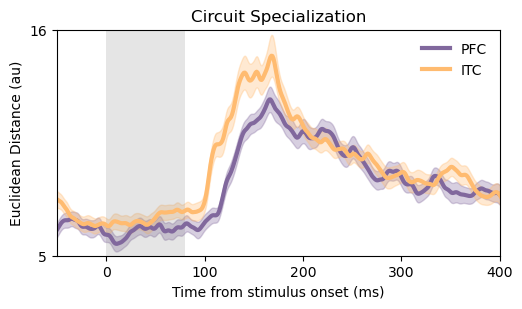

In [22]:
smooth_win = 2
plot_xlim = [-50,400]
plot_ylim = [5,16]
figure_size = np.array((2.5,1.5)) * 2

m_plot([dist_pfc,dist_itc], [color_pfc,color_itc], error_method='std', 
       smooth_win=smooth_win, labels=['PFC','ITC'], plot_title=f'Circuit Specialization', timepoints=time_stamps, figure_size=figure_size)

plt.xlabel('Time from stimulus onset (ms)')
plt.xlim([plot_xlim[0],plot_xlim[1]])
plt.xticks([0,100,200,300,400])

plt.ylabel('Euclidean Distance (au)')
plt.ylim(plot_ylim)
plt.yticks([plot_ylim[0],plot_ylim[1]])

# plt.savefig(f'{FigDir}axes_align.svg', dpi=1000)

In [36]:
corr_itc, corr_pfc = [], []
for icycle in tqdm(range(cycle_num)):
    tmp_corr_itc, tmp_corr_pfc = [], []

    for itime in range(wt_fb_itc.shape[2]):
        tmp_corr_itc.append(spearman(wt_fb_itc[icycle,:,itime],wt_anim_itc[icycle,:,itime])[0])
        tmp_corr_pfc.append(spearman(wt_fb_pfc[icycle,:,itime],wt_anim_pfc[icycle,:,itime])[0])
    
    corr_itc.append(np.array(tmp_corr_itc))
    corr_pfc.append(np.array(tmp_corr_pfc))

corr_itc = np.array(corr_itc)
corr_pfc = np.array(corr_pfc)

  0%|          | 0/200 [00:00<?, ?it/s]

([<matplotlib.axis.YTick at 0x2217c29a390>,
 [Text(0, -0.3, '−0.3'), Text(0, 0.0, '0.0'), Text(0, 0.3, '0.3')])

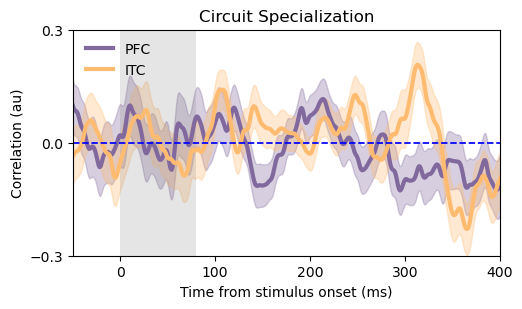

In [48]:
smooth_win = 2
plot_xlim = [-50,400]
plot_ylim = [-.3,.3]
figure_size = np.array((2.5,1.5)) * 2

m_plot([corr_pfc,corr_itc], [color_pfc,color_itc], error_method='std', 
       smooth_win=smooth_win, labels=['PFC','ITC'], plot_title=f'Circuit Specialization', timepoints=time_stamps, figure_size=figure_size)

plt.axhline(0, ls='--', c='b', lw=figure_size[0]*.25)

plt.xlabel('Time from stimulus onset (ms)')
plt.xlim([plot_xlim[0],plot_xlim[1]])
plt.xticks([0,100,200,300,400])

plt.ylabel('Correlation (au)')
plt.ylim(plot_ylim)
plt.yticks([plot_ylim[0],0,plot_ylim[1]])

# plt.savefig(f'{FigDir}axes_align.svg', dpi=1000)

  0%|          | 0/200 [00:00<?, ?it/s]

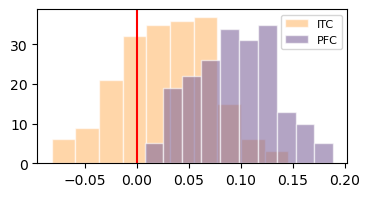

In [179]:
fig_sz = np.array((2,1)) * 2

resp_win = [70,220]
idx_resp_win = np.where((time_stamps > resp_win[0]) & (time_stamps < resp_win[1]))[0]

ave_cosine_itc, ave_cosine_pfc = [], []
for icycle in tqdm(range(cycle_num)):
    tmp_data_fb_itc = np.nanmean(resp_itc[:,idx_rand_fb[icycle],:][:,:,idx_resp_win], axis=2).T
    lda_fb = LDA(shrinkage='auto', solver='eigen').fit(tmp_data_fb_itc, labels_fb)
    axis_fb = lda_fb.coef_[0].reshape(1,-1)

    tmp_data_anim_itc = np.nanmean(resp_itc[:,idx_rand_anim[icycle],:][:,:,idx_resp_win], axis=2).T
    lda_anim = LDA(shrinkage='auto', solver='eigen').fit(tmp_data_anim_itc, labels_anim)
    axis_anim = lda_anim.coef_[0].reshape(1,-1)

    ave_cosine_itc.append(cosine(axis_anim, axis_fb))

    tmp_data_fb_pfc = np.nanmean(resp_pfc[:,idx_rand_fb[icycle],:][:,:,idx_resp_win], axis=2).T
    lda_fb = LDA(shrinkage='auto', solver='eigen').fit(tmp_data_fb_pfc, labels_fb)
    axis_fb = lda_fb.coef_[0].reshape(1,-1)

    tmp_data_anim_pfc = np.nanmean(resp_pfc[:,idx_rand_anim[icycle],:][:,:,idx_resp_win], axis=2).T
    lda_anim = LDA(shrinkage='auto', solver='eigen').fit(tmp_data_anim_pfc, labels_anim)
    axis_anim = lda_anim.coef_[0].reshape(1,-1)

    ave_cosine_pfc.append(cosine(axis_anim, axis_fb))

ave_cosine_itc = np.array(ave_cosine_itc).reshape(-1,1)
ave_cosine_pfc = np.array(ave_cosine_pfc).reshape(-1,1)

# print(f'p= {permutation_test(data=(ave_cosine_itc.reshape(1,-1)[0], null_dist), statistic=test_stat, vectorized=True, axis=0, random_state=15, n_resamples=permute_reps).pvalue}')

plt.figure(figsize=fig_sz)
plt.hist(ave_cosine_itc, color=color_itc_n[:3], alpha=.6, edgecolor=[1,1,1], label='ITC')
plt.hist(ave_cosine_pfc, color=color_pfc_n[:3], alpha=.6, edgecolor=[1,1,1], label='PFC')
plt.axvline(0, color='r')
plt.legend(fontsize=fig_sz[0]*2)

  0%|          | 0/200 [00:00<?, ?it/s]

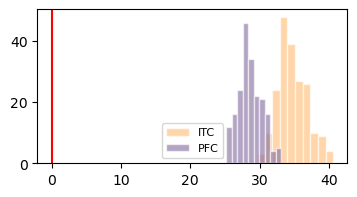

In [188]:
fig_sz = np.array((2,1)) * 2

resp_win = [70,220]
idx_resp_win = np.where((time_stamps > resp_win[0]) & (time_stamps < resp_win[1]))[0]

ave_eudist_itc, ave_eudist_pfc = [], []
for icycle in tqdm(range(cycle_num)):
    tmp_data_fb_itc = np.nanmean(resp_itc[:,idx_rand_fb[icycle],:][:,:,idx_resp_win], axis=2).T
    lda_fb = LDA(shrinkage='auto', solver='eigen').fit(tmp_data_fb_itc, labels_fb)
    axis_fb = lda_fb.coef_[0].reshape(1,-1)

    tmp_data_anim_itc = np.nanmean(resp_itc[:,idx_rand_anim[icycle],:][:,:,idx_resp_win], axis=2).T
    lda_anim = LDA(shrinkage='auto', solver='eigen').fit(tmp_data_anim_itc, labels_anim)
    axis_anim = lda_anim.coef_[0].reshape(1,-1)

    ave_eudist_itc.append(eu_dist(axis_fb, axis_anim))

    tmp_data_fb_pfc = np.nanmean(resp_pfc[:,idx_rand_fb[icycle],:][:,:,idx_resp_win], axis=2).T
    lda_fb = LDA(shrinkage='auto', solver='eigen').fit(tmp_data_fb_pfc, labels_fb)
    axis_fb = lda_fb.coef_[0].reshape(1,-1)

    tmp_data_anim_pfc = np.nanmean(resp_pfc[:,idx_rand_anim[icycle],:][:,:,idx_resp_win], axis=2).T
    lda_anim = LDA(shrinkage='auto', solver='eigen').fit(tmp_data_anim_pfc, labels_anim)
    axis_anim = lda_anim.coef_[0].reshape(1,-1)

    ave_eudist_pfc.append(eu_dist(axis_fb, axis_anim))

ave_eudist_itc = np.array(ave_eudist_itc).reshape(-1,1)
ave_eudist_pfc = np.array(ave_eudist_pfc).reshape(-1,1)

# print(f'p= {permutation_test(data=(ave_eudist_itc.reshape(1,-1)[0], null_dist), statistic=test_stat, vectorized=True, axis=0, random_state=15, n_resamples=permute_reps).pvalue}')

plt.figure(figsize=fig_sz)
plt.hist(ave_eudist_itc, color=color_itc_n[:3], alpha=.6, edgecolor=[1,1,1], label='ITC')
plt.hist(ave_eudist_pfc, color=color_pfc_n[:3], alpha=.6, edgecolor=[1,1,1], label='PFC')
plt.axvline(0, color='r')
plt.legend(fontsize=fig_sz[0]*2)


Correlation = SignificanceResult(statistic=-0.060656990068754774, pvalue=0.5104639118707728)
Mann-Whitney = MannwhitneyuResult(statistic=3685.0, pvalue=6.348934480668017e-11)


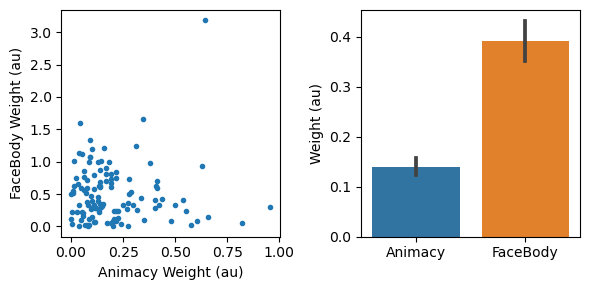

In [172]:
itime = 180
icycle = 0

lda_fb = LDA(shrinkage='auto', solver='eigen').fit(resp_pfc[:,idx_rand_fb[icycle],itime].T, labels_fb)
axis_fb = lda_fb.coef_[0]

lda_anim = LDA(shrinkage='auto', solver='eigen').fit(resp_pfc[:,idx_rand_anim[icycle],itime].T, labels_anim)
axis_anim = lda_anim.coef_[0]

estimator = 'median'
error_method = 'se'
figure_size = np.array((2,1)) * 3
fig1, ax = plt.subplots(nrows=1, ncols=2, figsize=figure_size)

ax[0].scatter(abs(axis_anim), abs(axis_fb), s=figure_size[0]*1.5)
ax[0].set_xlabel('Animacy Weight (au)')
ax[0].set_ylabel('FaceBody Weight (au)')
print(f'Correlation = {spearman(abs(axis_anim), abs(axis_fb))}')

weight_compare = sns.barplot(ax=ax[1], data=[abs(axis_anim), abs(axis_fb)], estimator=estimator, errorbar=error_method)
ax[1].set_ylabel('Weight (au)')
weight_compare.set(xticklabels=["Animacy", "FaceBody"])
print(f"Mann-Whitney = {mnu(abs(axis_anim), abs(axis_fb), nan_policy='omit')}")

plt.tight_layout()

In [88]:
def L1L2_Sparsity(data_arr):
    l1_norm = np.sum(np.abs((data_arr)))
    l2_norm = np.sqrt(np.sum((data_arr**2)))
    return (l1_norm / l2_norm) / len(data_arr)

sp_fb_itc, sp_fb_pfc = np.zeros_like(cosine_itc) * np.nan, np.zeros_like(cosine_pfc) * np.nan
sp_anim_itc, sp_anim_pfc = np.zeros_like(cosine_itc) * np.nan, np.zeros_like(cosine_pfc) * np.nan

for icycle in tqdm(range(cycle_num)):

    for itime in range(wt_fb_itc.shape[2]):
        sp_fb_itc[icycle,itime] = L1L2_Sparsity(wt_fb_itc[icycle,:,itime])
        sp_fb_pfc[icycle,itime] = L1L2_Sparsity(wt_fb_pfc[icycle,:,itime])
        
        sp_anim_itc[icycle,itime] = L1L2_Sparsity(wt_anim_itc[icycle,:,itime])
        sp_anim_pfc[icycle,itime] = L1L2_Sparsity(wt_anim_pfc[icycle,:,itime])


  0%|          | 0/200 [00:00<?, ?it/s]

Text(7.347222222222223, 0.5, 'Sparsity (au)')

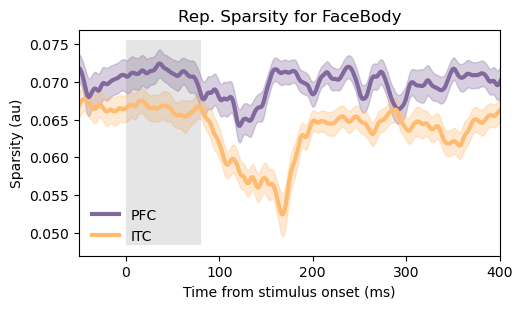

In [85]:
smooth_win = 2
plot_xlim = [-50,400]
plot_ylim = [-.3,.3]
figure_size = np.array((2.5,1.5)) * 2

m_plot([sp_fb_pfc,sp_fb_itc], [color_pfc,color_itc], error_method='std', 
       smooth_win=smooth_win, labels=['PFC','ITC'], plot_title=f'Rep. Sparsity for FaceBody', timepoints=time_stamps, figure_size=figure_size)

plt.xlabel('Time from stimulus onset (ms)')
plt.xlim([plot_xlim[0],plot_xlim[1]])
plt.xticks([0,100,200,300,400])

plt.ylabel('Sparsity (au)')
# plt.ylim(plot_ylim)
# plt.yticks([plot_ylim[0],0,plot_ylim[1]])

# plt.savefig(f'{FigDir}axes_align.svg', dpi=1000)

Text(-1.5277777777777768, 0.5, 'Sparsity (au)')

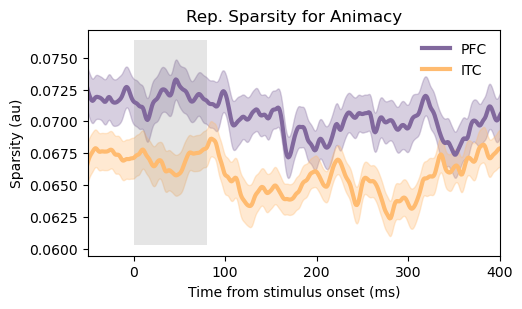

In [86]:
smooth_win = 2
plot_xlim = [-50,400]
plot_ylim = [-.3,.3]
figure_size = np.array((2.5,1.5)) * 2

m_plot([sp_anim_pfc,sp_anim_itc], [color_pfc,color_itc], error_method='std', 
       smooth_win=smooth_win, labels=['PFC','ITC'], plot_title=f'Rep. Sparsity for Animacy', timepoints=time_stamps, figure_size=figure_size)

plt.xlabel('Time from stimulus onset (ms)')
plt.xlim([plot_xlim[0],plot_xlim[1]])
plt.xticks([0,100,200,300,400])

plt.ylabel('Sparsity (au)')
# plt.ylim(plot_ylim)
# plt.yticks([plot_ylim[0],0,plot_ylim[1]])

# plt.savefig(f'{FigDir}axes_align.svg', dpi=1000)